# Baidu API to translate Cantonese to Simplified Chinese

In [1]:
import pandas as pd
import numpy as np
import re
import jieba
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('../data/sentiment_analysis_latest.xlsx')

In [ ]:
import requests
import json

def main():
    api_key = 'xxxx'
    secret_key = 'xxxx'
    url = f"xxxx"
    
    payload = ""
    headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    
    response = requests.request("POST", url, headers=headers, data=payload)
    
    print(response.text)
    

if __name__ == '__main__':
    main()

In [ ]:
# This code shows an example of text translation from English to Simplified-Chinese.
# This code runs on Python 2.7.x and Python 3.x.
# You may install `requests` to run this code: pip install requests
# Please refer to `https://api.fanyi.baidu.com/doc/21` for complete api document

import requests
import random
import json

access_token = "xxxx"
token = access_token
url = 'xxxx' + token


# For list of language codes, please refer to `https://ai.baidu.com/ai-doc/MT/4kqryjku9#语种列表`
from_lang = 'yue' # example: en
to_lang = 'zh' # example: zh
term_ids = '' # 术语库id，多个逗号隔开


# Build request
headers = {'Content-Type': 'application/json'}
msg_sc_list = []

for i in range(4627, len(df['msg_replace'])):
    q = df['msg_replace'][i]
    payload = {'q': q, 'from': from_lang, 'to': to_lang, 'termIds' : term_ids}

    # Send request
    r = requests.post(url, params=payload, headers=headers)
    result = r.json()
    msg_sc = result['result']['trans_result'][0]['dst']

    # Show response
    print(msg_sc)
    msg_sc_list.append(msg_sc)

In [ ]:
#df.to_excel('../data/bert_data/sentiment_analysis_sc_message.xlsx', index=False)

In [2]:
df = pd.read_excel('../data/bert_data/sentiment_analysis_sc_message.xlsx')

In [3]:
replace_tag = {'positive':2, 'neutral':1, 'negative':0}
df['sentiment_label']= df['sentiment_label'].replace(replace_tag)

In [4]:
df_sent = df[['msg_sc', 'sentiment_label']]

In [5]:
df_sent['sentiment_label'].value_counts()

1    3267
0    1943
2     959
Name: sentiment_label, dtype: int64

# BERT training

In [6]:
import transformers
transformers.__version__ 

'4.24.0'

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [9]:
# Load pre-trained BERT model and tokenizer from Hugging Face
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=3)  # 3 labels: 0, 1, 2
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# Instantiate data
train_data, val_data = train_test_split(df_sent, test_size=0.1)

# Initialize dataset and dataloaders
train_dataset = SentimentDataset(
    texts=train_data['msg_sc'].to_numpy(),
    labels=train_data['sentiment_label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

val_dataset = SentimentDataset(
    texts=val_data['msg_sc'].to_numpy(),
    labels=val_data['sentiment_label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Setup GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)  # You can adjust learning rate

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
tokenizer

PreTrainedTokenizer(name_or_path='bert-base-chinese', vocab_size=21128, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [10]:
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [11]:
from sklearn.metrics import accuracy_score

num_epochs = 10  # Set the number of epochs
train_loss_values = []
train_acc_values = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0
    all_labels = []
    all_preds = []
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)  # Get the predicted class for each example in the batch
        all_labels.append(labels.cpu().numpy())  # Append the actual labels
        all_preds.append(preds.cpu().numpy())    # Append the model's predictions
        
    # Calculate and print the average loss over the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")
    
    # Flatten lists of predictions and labels and calculate accuracy
    flat_labels = [item for sublist in all_labels for item in sublist]
    flat_preds = [item for sublist in all_preds for item in sublist]
    train_acc = accuracy_score(flat_labels, flat_preds)
    
    train_loss_values.append(avg_train_loss)
    train_acc_values.append(train_acc)
    
    print(f"Training Accuracy: {train_acc:.4f}")

Epoch [1/10], Loss: 0.6419
Training Accuracy: 0.7239
Epoch [2/10], Loss: 0.4261
Training Accuracy: 0.8321
Epoch [3/10], Loss: 0.2532
Training Accuracy: 0.9067
Epoch [4/10], Loss: 0.1626
Training Accuracy: 0.9433
Epoch [5/10], Loss: 0.1118
Training Accuracy: 0.9606
Epoch [6/10], Loss: 0.0764
Training Accuracy: 0.9744
Epoch [7/10], Loss: 0.0706
Training Accuracy: 0.9751
Epoch [8/10], Loss: 0.0487
Training Accuracy: 0.9822
Epoch [9/10], Loss: 0.0714
Training Accuracy: 0.9766
Epoch [10/10], Loss: 0.0514
Training Accuracy: 0.9831


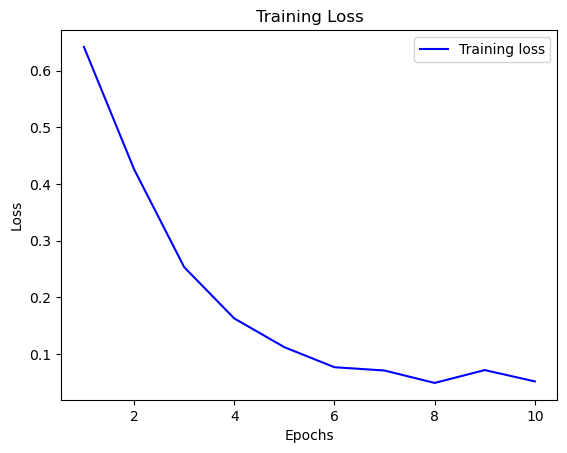

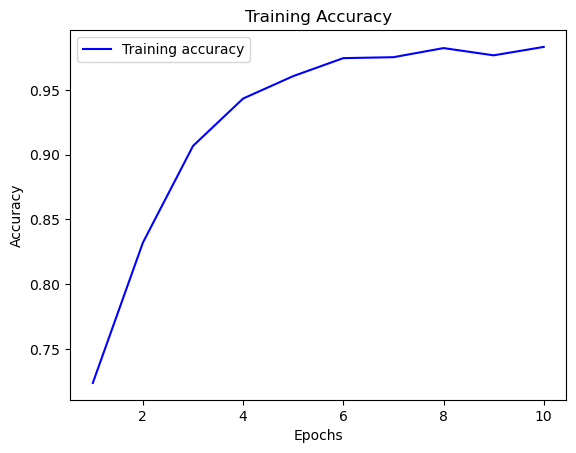

In [12]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_acc_values, 'b', label='Training accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
from sklearn.metrics import f1_score

model.eval()
total_eval_loss = 0
all_labels = []
all_preds = []

for batch in val_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)

    with torch.no_grad():  
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    loss = outputs.loss
    logits = outputs.logits

    total_eval_loss += loss.item()

    logits = logits.detach().cpu().numpy()
    labels = labels.to('cpu').numpy()
    
    preds = np.argmax(logits, axis=1)
    all_labels.append(labels)
    all_preds.append(preds)

# Flatten the list of results for scikit-learn
flat_labels = [item for sublist in all_labels for item in sublist]
flat_preds = [item for sublist in all_preds for item in sublist]

# Calculate metrics
avg_val_loss = total_eval_loss / len(val_loader)
val_accuracy = accuracy_score(flat_labels, flat_preds)
val_f1 = f1_score(flat_labels, flat_preds, average='weighted')  # weighted average of f1 score for multi-class classification

print(f"Test Loss: {avg_val_loss:.4f}")
print(f"Test Accuracy: {val_accuracy:.4f}")
print(f"Test F1 Score: {val_f1:.4f}")

Test Loss: 1.0993
Test Accuracy: 0.7844
Test F1 Score: 0.7843
